# Author: Omkar Bare

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

import os, sys, re, pickle, glob
import urllib.request
import zipfile


from tqdm.auto import tqdm

import librosa
from librosa import feature

import IPython.display as ipd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Problem Definition:

How successfully can we predict if a particular audio was captured indoors or outdoors, given the previously recorded data of audios that have been labelled according to its location setting?

The indoor and outdoor audio samples present in the data are recorded at various locations and have different types of acoustic environments, which makes the task of classification very challenging.

In [ ]:
#import dataset csv
sounds_data = pd.read_csv('/content/drive/MyDrive/ml_sounds_data/MLEndLS.csv').set_index('file_id')

# Machine Learning pipeline

The ML Pipeline used in this project takes input as raw audio files along with its labels and estimates whether the audio was captured indoors or outdoors.

The pipeline begins with passing the raw audio data to a feature extraction function which extracts the necessary features from the raw data. 

The extracted data along with the corresponding features are then split into training, validation and test dataset. The training data consists of 60% of the total dataset and validation and test datasets consist of 20% each of the total dataset. The data is split before any kind of preprocessing to avoid data leakage problem. Data leakage problem occurs when knowledge of the hold-out test set leaks into the dataset used to train the model which can result in an incorrect estimate of model performance when making predictions on new data.

The training, validation and testing data are then Z-score normalized. For the machine learning model to train effectively, Z-score normalisation aims to convert the values of features to a common scale without distorting disparities in the ranges of values or losing information.
Then in the next step, pre-processing is done on the training data where the imbalanced classes are handled.

Then the model is trained using preprocessed training  dataset and and validated using validation datasets. Further, hyperparameter Tuning is carried out to select the best parameter for the model using Grid Search with cross-validation.

Finally, the model performance is checked on the test dataset.

# Transformation Stage:

The transformation stage in this project consists of feature extraction which takes as input the raw audio data along with corresponding labels and outputs the extracted features and their corresponding labels.

As the predictor space for audio data consists of hundreds of thousands of dimensions, extracting a few features to use as predictors will be important to train the model effectively.

For this project, several custom features along with a few features extracted through the librosa library are used as predictors.

Following features are extracted from the raw audio data:

Custom Features:
1. power: power of audio time series
2. pitch_mean: mean of audio pitch
3. pitch_mean: standard deviation of audio pitch
4. voiced_fr: fraction of voiced region

Features from librosa library (https://librosa.org/doc/latest/feature.html):
5. chroma_stft : chromagram from a waveform or power spectrogram
6. spectral_centroid: spectral centroid
7. spectral_bandwidth: p'th-order spectral bandwidth.
8. spectral_contrast: spectral contrast
9. spectral_rolloff: roll-off frequency
10. spectral_flatness:  spectral flatness
11. rms: root-mean-square (RMS) value for each frame
12. zero_crossing_rate: zero-crossing rate of an audio time series

In [ ]:
# import audio's path
sample_path = '/content/drive/MyDrive/ml_sounds_data/sounds_data/*.wav'
audio_paths = glob.glob(sample_path)

In [ ]:
# function to extract pitch of audio
def getPitch(x,fs,winLen=0.02):
  p = winLen * fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0, voiced_flag

In [ ]:
# features to be extracted from librosa library
func_double_param = [
  feature.chroma_stft,
  feature.spectral_centroid,
  feature.spectral_bandwidth,
  feature.spectral_contrast,
  feature.spectral_rolloff
]
 
func_single_param = [
  feature.spectral_flatness,
  feature.rms,
  feature.zero_crossing_rate
]

In [ ]:
# function to extract custom features and features from librosa library and 
def get_feature_vector(x, fs): 

  f0, voiced_flag = getPitch(x,fs,winLen=0.02)

  power = np.sum(x**2)/len(x)
  pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
  pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
  voiced_fr = np.mean(voiced_flag)

  xi = [power,pitch_mean,pitch_std,voiced_fr]

  feature_vect1 = [ np.mean(funct(x, fs)) for funct in func_double_param ]
  feature_vect2 = [ np.mean(funct(x)) for funct in func_single_param ] 
  feature_vect_combined = feature_vect1 + feature_vect2

  feature_vector = xi + feature_vect_combined

  return feature_vector

In [ ]:
# function to get 
def get_features_labels(files, data):
  '''
  get all the features and corresponding labels from the audio files.
  '''
  features = []
  labels = []

  for file in tqdm(files):
    file_name = file.split('/')[-1]
    label = data.loc[file_name]['in_out'] == 'indoor'

    x, fs = librosa.load(file, sr=None) 

    feature_vector = get_feature_vector(x, fs)
    

    features.append(feature_vector)
    labels.append(label)

  return np.array(features), np.array(labels)

In [ ]:
# set flag = 1 to run this cell (takes long time  to run)
flag = 0
if flag == 1:
  features, labels = get_features_labels(audio_paths, data = sounds_data)

In [ ]:
# np.save('/content/drive/MyDrive/ml_sounds_data/extracted_features.npy', features)
# np.save('/content/drive/MyDrive/ml_sounds_data/extracted_labels.npy', labels)

In [ ]:
features = np.load('/content/drive/MyDrive/ml_sounds_data/extracted_features.npy')
labels = np.load('/content/drive/MyDrive/ml_sounds_data/extracted_labels.npy')

In [ ]:
display(len(features), len(labels))

2500

2500

# Modelling

In this project, two models are compared which are listed down below and the best model based on validation accuracy is selected from these models.

Following models are tried in this project as there are many features with relatively less number of samples.

1. 'Support Vector Machines' (SVM): 
The main benefit of employing an SVM model can be that it can capture far more intricate correlations between datapoints and labels without the need for difficult transformations to make the data separable.

2. 'Random Forest Classifier':
In this model several decision tree classifiers are fitted to different subsamples of the dataset, and averaging is used to increase the predicted accuracy and reduce overfitting.

# Methodology

Models will be trained on the training dataset and will be selected on how well it does on the validation datset. The models will be evaluted on the basis on accuracy, precision, recall, f1 score and confusion matrix.

The best performing model will be selected as our base model.

Hyper-parameter tunning will be carried out to select the best parameters for the base model.

Finally, the model will be evaluated on the test dataset.

In [ ]:
# function to evaluate the models prediction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_preds(y_true, y_preds):
    '''
    Evalutes the metrics of classification model given the actual and predicted labels.
    y_true : actual labels
    y_preds : predicted labels
    '''
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    print(f'accuracy: {accuracy * 100:.2f}%')
    print(f'precision: {precision:.2f}')
    print(f'recall: {recall:.2f}')
    print(f'f1: {f1:.2f}')
    
    metric_dict = {'accuracy': round(accuracy, 2),
                   'precision': round(precision, 2),
                   'recall': round(recall, 2),
                   'f1': round(f1, 2)}
    return metric_dict

# Dataset:

The entire dataset will be split into three parts:

1. Training dataset: this dataset will be approximately 60% of the entire data and will be used for model training.

2. Validation dataset: this dataset will be approximately 20% of the entire data and will be used to evalute and improve the selected model.

3. Testing dataset: this dataset will be approximately 20% of the entire data and will be used to evaluate the final model.

Before training the model, all the data will be Z-score normalized to convert the values of features to a common scale without distorting disparities in the ranges of values or losing information.

The labels in the training dataset will be balanced by dropping certain observations of majority class.

Finally, model will be trained and validated on this preprocessed training and validation dataset 

In [ ]:
# display 3 random raw audio files
for _ in range(3):
  n = np.random.randint(10)
  display(ipd.Audio(audio_paths[n]))

In [ ]:
feature_columns = columns=['power', 'pitch_mean', 'pitch_std',
                           'voiced_fr','chroma_stft', 'spectral_centroid', 
                           'spectral_bandwidth','spectral_contrast', 
                           'spectral_rolloff','spectral_flatness', 'rms', 'zero_crossing_rate']

In [ ]:
# display extracted features 
extracted_data_features = pd.DataFrame(features, columns=feature_columns)
display(extracted_data_features.head())

power  pitch_mean  pitch_std  voiced_fr  chroma_stft  spectral_centroid  \
0  0.000754  126.443580   9.911017   0.056782     0.579022        3765.455880   
1  0.000261  236.657708  48.055864   0.100877     0.590075        1905.874890   
2  0.001103    0.000000   0.000000   0.000000     0.663131        2255.824115   
3  0.002098  162.432598  14.204691   0.091057     0.569720        1449.174936   
4  0.000989  195.189920  22.814062   0.042846     0.540099        1393.507133   

   spectral_bandwidth  spectral_contrast  spectral_rolloff  spectral_flatness  \
0         3846.840544          18.536780       8383.514501           0.003111   
1         2309.638836          16.539609       3884.948730           0.003234   
2         2812.387319          17.265569       4853.864327           0.000125   
3         1635.756234          17.979344       2914.055116           0.000036   
4         1943.787195          17.162056       2725.751882           0.000034   

        rms  zero_crossing_rate  
0  0.025201            0.096887  
1  0.013513            0.045240  
2  0.026644            0.052278  
3  0.037036            0.040437  
4  0.027714            0.029864

In [ ]:
# split the data into training(60%), validation(20%) and testing(20%)
from sklearn.model_selection import train_test_split

X = features
y = labels

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [ ]:
# Z-Score Normalize Data
from scipy.stats import zscore

X_train = zscore(X_train)
X_val = zscore(X_val)
X_test = zscore(X_test)

In [ ]:
training_data = pd.DataFrame(X_train)
training_data['target'] = y_train
display(training_data.head())

0         1         2         3         4         5         6  \
0 -0.637463 -0.226739 -0.446237 -0.264813  1.189669 -0.491383 -0.205882   
1  0.497072 -0.719933 -0.808702 -0.429903  0.846873  0.004856  0.603043   
2 -0.114170 -0.073788  2.036651 -0.676652  1.046871 -0.851116 -1.007231   
3 -0.593851  0.562018  0.166235 -0.419862  0.082097  0.233837  1.706259   
4 -0.484123  1.926777 -0.641933 -0.884572  0.755298 -1.273641 -1.280204   

          7         8         9        10        11  target  
0 -0.772248 -0.457249 -0.161308 -1.028388 -0.616460   False  
1 -0.419705 -0.176080 -0.085495  1.018430 -0.563987   False  
2 -0.266481 -0.899551 -0.037565  0.204953 -0.610087   False  
3 -0.446399  0.002989 -0.118851 -0.908468 -0.576780    True  
4  0.787706 -1.205746  0.025114 -0.462183 -1.005875   False

In [ ]:
label_counts = training_data['target'].value_counts()
display(label_counts)

False    847
True     753
Name: target, dtype: int64

In [ ]:
# balance the data with respect to target variable
diff = label_counts[0] - label_counts[1]
idx = training_data.index.values[training_data['target'] == False][:diff]
new_training_data = training_data.drop(idx)

In [ ]:
new_label_counts = new_training_data['target'].value_counts()
display(new_label_counts)

True     753
False    753
Name: target, dtype: int64

In [ ]:
# updated training data and labels
y_train = np.array(new_training_data['target'])
new_training_data = new_training_data.drop('target', axis=1)
X_train = np.array(new_training_data)

In [ ]:
new_training_data.head()

0         1         2         3         4         5         6  \
3  -0.593851  0.562018  0.166235 -0.419862  0.082097  0.233837  1.706259   
5  -0.570867 -0.226501 -0.119077 -0.448607  0.274566  1.127847  1.768717   
7  -0.498271  1.385529  0.259023  0.825686 -2.099377  1.288321  0.897466   
8  -0.615267 -0.809025 -0.721906  3.070304  1.431775 -1.540803 -0.861967   
10  0.435816  1.173456  3.012907 -0.280540 -0.965762 -0.460247 -0.052827   

           7         8         9        10        11  
3  -0.446399  0.002989 -0.118851 -0.908468 -0.576780  
5  -1.493279  0.940650  0.028538 -0.958892  0.402759  
7   1.029199  1.066686 -0.109299 -0.569060  1.173623  
8  -0.903889 -1.664135 -0.161815 -0.962482 -1.377822  
10 -0.060374 -0.716390 -0.102382  0.935336 -0.437906

# Results:

## Support Vector Machines Model:

In [ ]:
from sklearn import svm

svm_model  = svm.SVC(random_state=10)
svm_model.fit(X_train, y_train)

X_train_preds = svm_model.predict(X_train)
X_val_preds = svm_model.predict(X_val)

In [ ]:
# training data metrics
SVM_X_train_metrics = evaluate_preds(y_train, X_train_preds)

accuracy: 77.49%
precision: 0.74
recall: 0.84
f1: 0.79


In [ ]:
# validation data metrics
SVM_X_val_metrics = evaluate_preds(y_val, X_val_preds)

accuracy: 74.00%
precision: 0.68
recall: 0.79
f1: 0.73


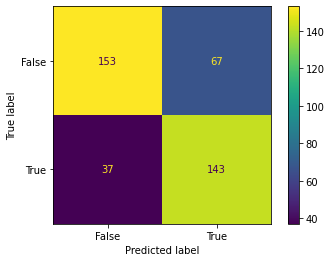

In [ ]:
from sklearn.metrics import plot_confusion_matrix

display(plot_confusion_matrix(svm_model, X_val, y_val))

## Random Forest Classifer Model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

X_train_preds_rfc = rfc.predict(X_train)
X_val_preds_rfc = rfc.predict(X_val)

In [ ]:
# training data metrics
rfc_X_train_metrics = evaluate_preds(y_train, X_train_preds_rfc)

accuracy: 100.00%
precision: 1.00
recall: 1.00
f1: 1.00


In [ ]:
# validation data metrics
rfc_X_val_metrics = evaluate_preds(y_val, X_val_preds_rfc)

accuracy: 71.25%
precision: 0.66
recall: 0.76
f1: 0.70


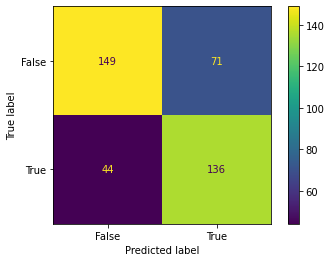

In [ ]:
from sklearn.metrics import plot_confusion_matrix

display(plot_confusion_matrix(rfc, X_val, y_val))

SVM model will be selected as the base model as the performance i.e accuracy score, precision, recall and f1 score is better as compared to the Random Forest Classifier.

## Hyper-parameter Tuning on base model (SVM model):

In [ ]:
svm_model.get_params() # parameters fro SVM

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 10,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
param_grid={'C': [0.1, 1, 25, 50],
            'gamma': ['scale', 1, 0.1, 0.01],
            'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(estimator=svm_model,
                      param_grid=param_grid, 
                      cv=3, # 3-fold cross validation
                      verbose=2,
                      refit=True) # set refit=True (default) to refit the best model on the full dataset 

gs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.1s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.1s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.1s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.3s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.2s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=

GridSearchCV(cv=3, estimator=SVC(random_state=10),
             param_grid={'C': [0.1, 1, 25, 50],
                         'gamma': ['scale', 1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [ ]:
gs_clf.best_params_

{'C': 25, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
# predictions after hyper-parameter tunning
X_train_preds = gs_clf.predict(X_train)
X_val_preds = gs_clf.predict(X_val)

In [ ]:
# predictions on training data 
X_train_metrics = evaluate_preds(y_train, X_train_preds) 

accuracy: 76.29%
precision: 0.72
recall: 0.86
f1: 0.78


In [ ]:
# base model acccuracy with 3-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(svm_model, X_train, y_train, cv=3).mean())

0.7257636122177956


The accuracy for the model have significantly improved after hyper-parameter tunning.

In [ ]:
# predictions on validation data 
X_val_metrics = evaluate_preds(y_val, X_val_preds) 

accuracy: 73.25%
precision: 0.67
recall: 0.82
f1: 0.73


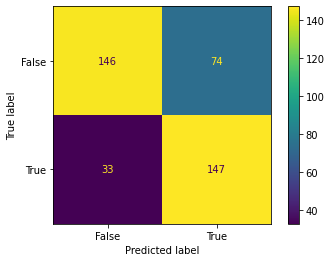

In [ ]:
from sklearn.metrics import plot_confusion_matrix

display(plot_confusion_matrix(gs_clf, X_val, y_val))

In [ ]:
# predictions on unseen data (test data)
gs_clf_Xtest_pred = gs_clf.predict(X_test)
gs_clf_Xtest_metrics = evaluate_preds(y_test, gs_clf_Xtest_pred)

accuracy: 76.00%
precision: 0.73
recall: 0.83
f1: 0.77


# Conclusion:

SVM model was selected as the base model as the performance i.e accuracy score, precision, recall and f1 score was better as compared to the Random Forest Classifier.

There was signifcant improvement after hyper-parameter tunning some of parameters of the base SVM model.

The final model can classify unseen audio data with approximately 75% accuracy that if the the audio was recorded indoors or outdoors.